### **Single-scale model vs. Multiscale model vs. Gated multiscale model.**

In [4]:
from notebooks import config
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

### **1. Calculate metrics (miou/oa/prod/user) for all val sites (only for new method).**

In [5]:
def metrics_eval(model_name='unet_scales_gate', model_trained_id='train_0'):
    oa, iou, prod, user = [], [], [], []
    scene_, truth_, wat_ = [], [], []
    print('model name:', model_name)
    print('trained model id:', model_trained_id)
    for idx in config.val_ids:
        scene_id = 'scene' + idx
        print('scene id: ', scene_id)
        path_valsite_as = 'data/dset/s1_ascend_clean/'+scene_id+'_s1as.tif'
        path_valsite_des = 'data/dset/s1_descend_clean/'+scene_id+'_s1des.tif'
        path_valsite_truth= 'data/dset/s1_truth_clean/'+scene_id+'_wat_truth.tif'
        path_valsite_wat = 'data/dset/valsite_wat_infer/'+model_name+'/as_des/'+model_trained_id+'/'+scene_id+'_s1_water.tif'
        scene_as, scene_as_info = readTiff(path_valsite_as)
        scene_des, scene_des_info = readTiff(path_valsite_des)
        truth, truth_info = readTiff(path_valsite_truth)
        wat, wat_info = readTiff(path_valsite_wat)
        scene = np.concatenate((scene_as, scene_des), axis=-1)
        scene_.append(scene); truth_.append(truth); wat_.append(wat)
        oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
        iou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
        oa.append(float(format(oa_i, '.4f'))), iou.append(float(format(iou_i, '.4f')))
        prod.append(float(format(prod_i, '.4f'))), user.append(float(format(user_i, '.4f')))

    oa_m, iou_m = float(format(np.mean(oa), '.4f')), float(format(np.mean(iou), '.4f'))
    prod_m, user_m = float(format(np.mean(prod), '.4f')), float(format(np.mean(user), '.4f'))

    metrics = {'prod':prod, 'user':user, 'iou ':iou, 'oa  ':oa}
    metrics_mean = {'prod_m':prod_m, 'user_m':user_m, 'iou_m':iou_m, 'oa_m':oa_m}
    return metrics, metrics_mean, scene_, truth_, wat_


In [8]:
metrics_unet_gscales, metrics_mean_unet_gscales, scenes, truth, wat_unet_gscales = \
                  metrics_eval(model_name='unet_scales_gate', model_trained_id='train_sel')
metrics_unet_scales, metrics_mean_unet_scales, scene, truth, wat_unet_scales = \
                  metrics_eval(model_name='unet_scales', model_trained_id='train_1')
metrics_unet, metrics_mean_unet, scene, truth, wat_unet = \
                  metrics_eval(model_name='unet', model_trained_id='train_0')


model name: unet_scales
trained model id: train_1
scene id:  scene01
scene id:  scene02
scene id:  scene03
scene id:  scene04
scene id:  scene05
scene id:  scene06
scene id:  scene07


In [9]:
print('------ unet_scales_gate ------')
pprint(metrics_unet_gscales, sort_dicts=False)
pprint(metrics_mean_unet_gscales, sort_dicts=False)
print('------ unet_scales ------')
pprint(metrics_unet_scales, sort_dicts=False)
pprint(metrics_mean_unet_scales, sort_dicts=False)
print('------ unet ------')
pprint(metrics_unet, sort_dicts=False)
pprint(metrics_mean_unet, sort_dicts=False)


------ unet_scales_gate ------
{'prod': [0.9905, 0.9386, 0.7379, 0.6898, 0.9927, 0.9898, 0.9958],
 'user': [0.9719, 0.9367, 0.9791, 0.9782, 0.9759, 0.9932, 0.9962],
 'iou ': [0.9629, 0.8826, 0.7265, 0.6794, 0.969, 0.9831, 0.992],
 'oa  ': [0.9954, 0.9857, 0.9224, 0.971, 0.9972, 0.996, 0.9972]}
{'prod_m': 0.905, 'user_m': 0.9759, 'iou_m': 0.8851, 'oa_m': 0.9807}
------ unet_scales ------
{'prod': [0.9927, 0.9298, 0.5993, 0.7573, 0.997, 0.9935, 0.997],
 'user': [0.9756, 0.9475, 0.9814, 0.8656, 0.9335, 0.9885, 0.997],
 'iou ': [0.9686, 0.8842, 0.5925, 0.6776, 0.9309, 0.9822, 0.994],
 'oa  ': [0.9961, 0.986, 0.8849, 0.9679, 0.9934, 0.9957, 0.9979]}
{'prod_m': 0.8952, 'user_m': 0.9556, 'iou_m': 0.8614, 'oa_m': 0.9746}
------ unet ------
{'prod': [0.9702, 0.9091, 0.674, 0.2763, 0.9952, 0.9847, 0.8742],
 'user': [0.9887, 0.9579, 0.9673, 0.9883, 0.9653, 0.9764, 0.9961],
 'iou ': [0.9595, 0.8742, 0.659, 0.2754, 0.9608, 0.9618, 0.8712],
 'oa  ': [0.9951, 0.985, 0.9026, 0.9352, 0.9964, 0.9907, 0.

#### Show the result water maps

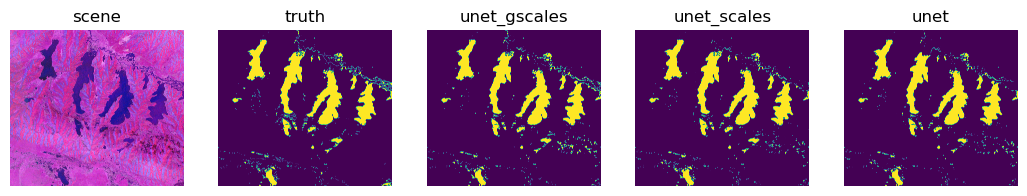

In [12]:
idx = 1    # 0-6
img_list = [scene[idx], truth[idx], wat_unet_gscales[idx], \
                                      wat_unet_scales[idx], wat_unet[idx]]
img_name_list = ['scene', 'truth', 'unet_gscales', 'unet_scales', 'unet']
clip_list = [2,0,0,0,0]
plt.figure(figsize=(13, 3))
imsShow(img_list, img_name_list, clip_list, \
            color_bands_list=None, axis=None, row=None, col=None)


### 2. Comparison among methods (plot smoothed metric for one test)

In [14]:
####################################################################
## 1. Model name and the selected metric
# id_model =  '10'
model_name = ['scales/unet_scales_gate/traset/as_des/train_sel', \
              'scales/unet_scales/traset/as_des/train_1', \
              'single/unet/traset/as_des/train_0']

# metric_name = 'val_miou'
path_metrics_single = config.root_proj + '/model/trained_model/' + model_name[0] + '_metrics.csv'
path_metrics_scales = config.root_proj + '/model/trained_model/' + model_name[1] + '_metrics.csv'
path_metrics_gscales = config.root_proj + '/model/trained_model/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_single = pd.read_csv(path_metrics_single)
metrics_scales = pd.read_csv(path_metrics_scales)
metrics_gscales = pd.read_csv(path_metrics_gscales)
# print(metrics_single.tail(2)); 
# print(metrics_scales.tail(2)); 
print(metrics_gscales.tail(2))



     tra_loss  tra_miou  val_loss  val_miou
298  0.351127  0.908403  0.169475  0.876643
299  0.346436  0.927296  0.168410  0.877607


In [15]:
### metrics smooth
metrics_single_smooth_x, metrics_single_smooth_y = smooth(metrics_single['val_miou'].to_numpy(), num_sam=20)
metrics_scales_smooth_x, metrics_scales_smooth_y = smooth(metrics_scales['val_miou'].to_numpy(), num_sam=20)
metrics_gscales_smooth_x, metrics_gscales_smooth_y = smooth(metrics_gscales['val_miou'].to_numpy(), num_sam=20)


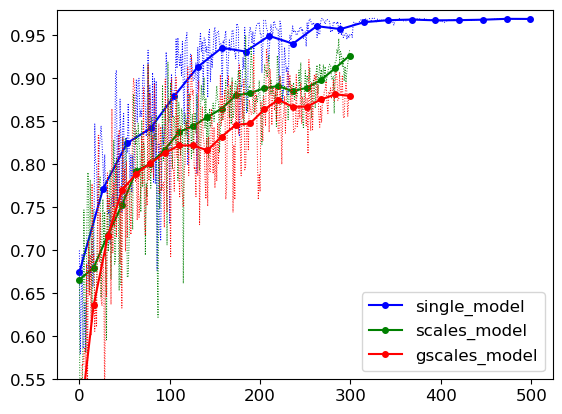

In [17]:
plt.rcParams.update({'font.size': 12})
color = ['blue', 'green', 'red']
plt.plot(metrics_single['val_miou'], color=color[0], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_single_smooth_x, metrics_single_smooth_y, color=color[0], \
            marker='o', markerfacecolor=color[0], markersize=4, linewidth=1.5, label= 'single_model')
plt.plot(metrics_scales['val_miou'], color=color[1], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_scales_smooth_x, metrics_scales_smooth_y, color=color[1], \
            marker='o', markerfacecolor = color[1], markersize=4, linewidth = 1.5,label= 'scales_model')

plt.plot(metrics_gscales['val_miou'], color=color[2], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_gscales_smooth_x, metrics_gscales_smooth_y, color=color[2], \
            marker='o', markerfacecolor=color[2], markersize=4, linewidth = 1.5, label= 'gscales_model')
plt.ylim(top=0.98, bottom=0.55)
plt.legend()



### 3. Comparison among methods (plot metric line with confidence interval)


In [18]:
### metrics path
dir_metric_gscales = config.root_proj + '/model/trained_model/scales/unet_scales_gate/traset/as_des'
paths_metric_gscales = glob(dir_metric_gscales + '/model_[0-9]_metrics.csv')
dir_metric_scales = config.root_proj + '/model/trained_model/scales/unet_scales/traset/as_des'
paths_metric_scales = glob(dir_metric_scales + '/model_[0-9]_metrics.csv')
dir_metric_single = config.root_proj + '/model/trained_model/single/unet/traset/as_des'
paths_metric_single = glob(dir_metric_single + '/model_[0-9]_metrics.csv')


### Concat metrics obtained by different iteration

In [19]:
metrics_gscales = csv_merge(paths_metric_gscales, i_csv='i_test', i_row='epoch', sam=5)
metrics_scales = csv_merge(paths_metric_scales, i_csv='i_test', i_row='epoch', sam=5)
metrics_single = csv_merge(paths_metric_single, i_csv='i_test', i_row='epoch', sam=5)
metrics_models = csv_merge([metrics_single, metrics_scales, metrics_gscales], i_csv='i_model')

print(metrics_models.head())
print('gscales model: ',metrics_gscales.shape)
print('models:', metrics_models.shape)



UnboundLocalError: local variable 'metrics_merge' referenced before assignment

In [9]:
### change the column name and the corresponding values
metrics_models_ = metrics_models.rename(columns={'i_model': 'Model'})
metrics_models_['Model'] = metrics_models_['Model'].replace([1], 'Single scale')
metrics_models_['Model'] = metrics_models_['Model'].replace([2], 'Multiple scales')
metrics_models_['Model'] = metrics_models_['Model'].replace([3], 'Gated multiple scales')


### Plot epoch-val_miou figure.

Text(0, 0.5, 'Validation MIoU (%)')

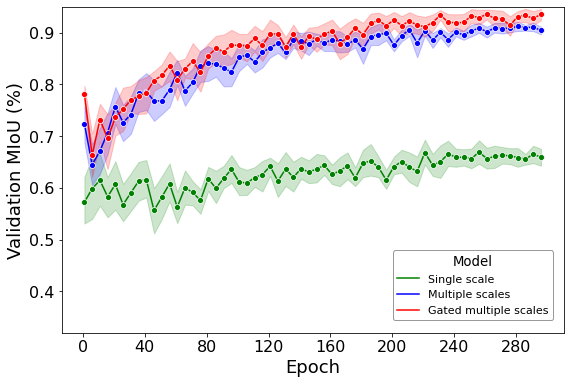

In [10]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(9,6))
ax_1 = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                      hue='Model', palette=colors, marker='o', ci=95, ax=ax_1)

# ax.legend().set_visible(False)
ax_1.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.49, -0.23, 0.5, 0.5))
ax_1.set_ylim(top=0.95, bottom=0.32)
y_major_locator=MultipleLocator(0.10)
ax_1.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(40)
ax_1.xaxis.set_major_locator(x_major_locator)
ax_1.set_xlabel('Epoch', fontsize=18)
ax_1.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_miou.png', bbox_inches='tight')



Text(0, 0.5, 'Validation MIoU (%)')

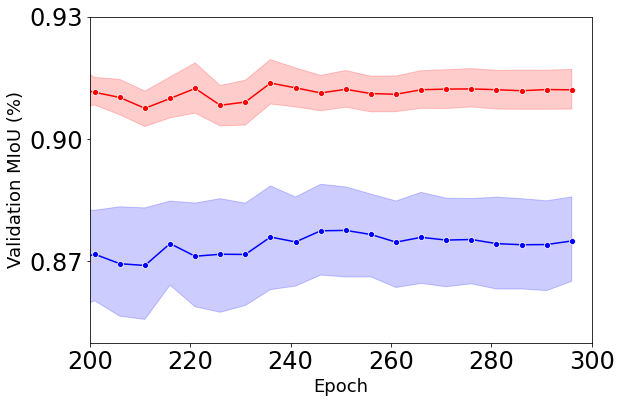

In [38]:
plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

ax.legend().set_visible(False)
ax.set_ylim(top=0.93, bottom=0.85)
ax.set_xlim(left=200, right=300)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.03)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_miou_l.png', bbox_inches='tight')



### Plot epoch-val_loss figure.

Text(0, 0.5, 'Validation loss')

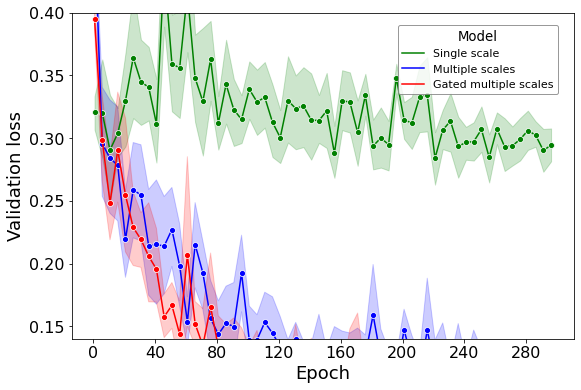

In [11]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

# ax.legend().set_visible(False)
ax.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.48, 0.48, 0.5, 0.5))
ax.set_ylim(top=0.4, bottom=0.14)
x_major_locator=MultipleLocator(40)
y_major_locator=MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_loss.png', bbox_inches='tight')



Text(0, 0.5, 'Validation loss')

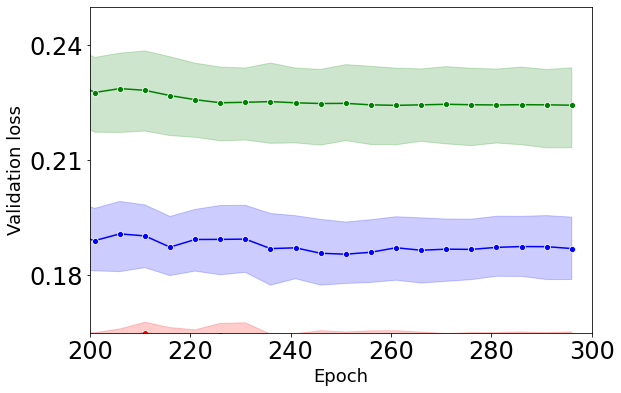

In [50]:
plt.rcParams.update({'font.size': 24})
colors = ['green', 'blue', 'red']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                  hue='Model', palette=colors, marker='o', ci=90, ax=ax)
ax.legend().set_visible(False)
ax.set_xlim(left=200, right=300)
ax.set_ylim(top=0.25, bottom=0.165)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.03)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_loss_l.png', bbox_inches='tight')



### **Visualize the results derived by different methods**

In [63]:
wat_gscales_, wat_scales_, wat_single_ = [], [], []
s1_as_, s2_scene_, truth_ = [], [], []

model_id = 'model_top1'
for idx in config.val_ids: 
    scene_id = 'scene' + idx
    path_valsite_wat_single = config.root_proj+'/data/dset/valsite_wat_infer/single/as_des/'+model_id+'/'+scene_id+'_s1_water.tif'
    path_valsite_wat_scales = config.root_proj+'/data/dset/valsite_wat_infer/scales/as_des/'+model_id+'/'+scene_id+'_s1_water.tif'
    path_valsite_wat_gscales= config.root_proj+'/data/dset/valsite_wat_infer/gscales/as_des/'+model_id+'/'+scene_id+'_s1_water.tif'
    path_valsite_as = config.root_proj+'/data/dset/s1_ascend/'+scene_id+'_s1as.tif'
    # path_valsite_des = config.root_proj+'/data/dset/s1_descend/'+scene_id+'_s1des.tif'
    path_valsite_truth = config.root_proj+'/data/dset/s1_truth/'+scene_id+'_wat_truth.tif'
    path_valsite_s2 = config.root_proj+'/data/dset/s2_img/'+scene_id+'_s2.tif'
    #### ----- read in data
    wat_gscales, wat_gscales_info = readTiff(path_valsite_wat_gscales)
    wat_scales, wat_scales_info = readTiff(path_valsite_wat_scales)
    wat_single, wat_single_info = readTiff(path_valsite_wat_single)
    s1_as, s1_as_info = readTiff(path_valsite_as)
    if int(idx) < 20: 
        s2_scene, s2_scene_info = readTiff(path_valsite_s2)
    truth, truth_info = readTiff(path_valsite_truth)    
    wat_gscales_.append(wat_gscales); wat_scales_.append(wat_scales)
    wat_single_.append(wat_single); s1_as_.append(s1_as)
    s2_scene_.append(s2_scene); truth_.append(truth)
print(len(wat_gscales_))



10


In [64]:
def local_dif(s1_scene, s2_scene, truth, wat_gscales, wat_scales, wat_single, region):
    ### focus on a local region 
    row_start, row_end, col_start, col_end = region
    s1_scene_l = s1_scene[row_start:row_end,col_start:col_end]
    s2_scene_l = s2_scene[row_start:row_end,col_start:col_end]
    truth_l = truth[row_start:row_end,col_start:col_end]
    wat_gscales_l = wat_gscales[row_start:row_end,col_start:col_end]
    wat_scales_l = wat_scales[row_start:row_end,col_start:col_end]
    wat_single_l = wat_single[row_start:row_end,col_start:col_end]
    ### calculate difference
    dif_gscales_l = (truth_l+1)*2 - wat_gscales_l
    dif_scales_l = (truth_l+1)*2 - wat_scales_l
    dif_single_l = (truth_l+1)*2 - wat_single_l
    return s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l


### Small-size water recognition （!!single-scale model supervior to gscale model）

In [65]:
### global variables
cmap_wat = ListedColormap(["white", "blue"])
cmap_err = ListedColormap(['red', 'black', 'blue','white'])


size: (3509, 3962)


Text(0.5, 1.0, 'single model')

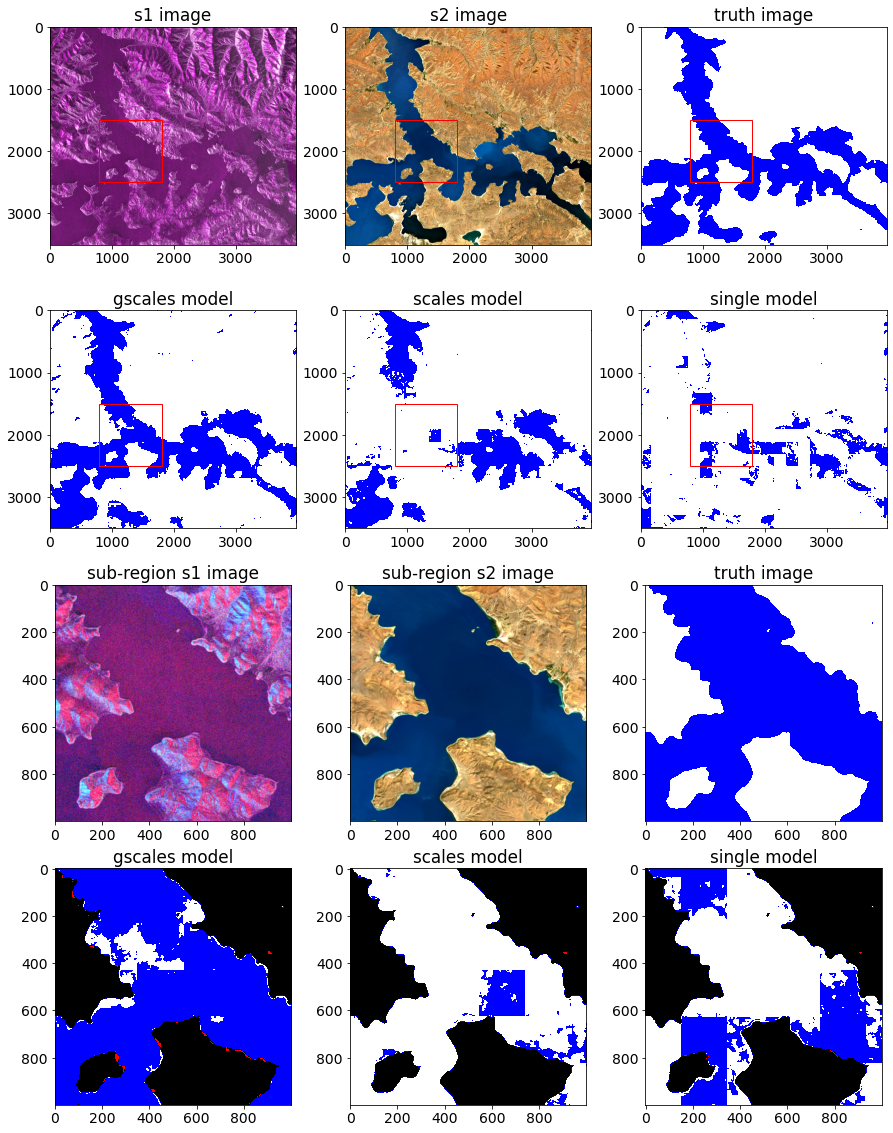

In [67]:
idx = 0  # 0-9 
plt.rcParams.update({'font.size': 14})
print('size:', truth_[idx].shape)
sub_region = [1500, 2500, 800, 1800]  ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
                s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)
plt.figure(figsize=(15,20))
### water map for selected scene
plt.subplot(4,3,1); imgShow(s1_as_[idx], color_bands=(0,1,0)); plt.title('s1 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,2); imgShow(s2_scene_[idx]); plt.title('s2 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none') # create Rectangle patch
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
### error map for the sub-region
plt.subplot(4,3,7); imgShow(s1_scene_l); plt.title('sub-region s1 image')
plt.subplot(4,3,8); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(4,3,9); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(4,3,10); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(4,3,11); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(4,3,12); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')



### Easy water body -> scene1 (✓1)

size: (3076, 3373)


Text(0.5, 1.0, 'single model')

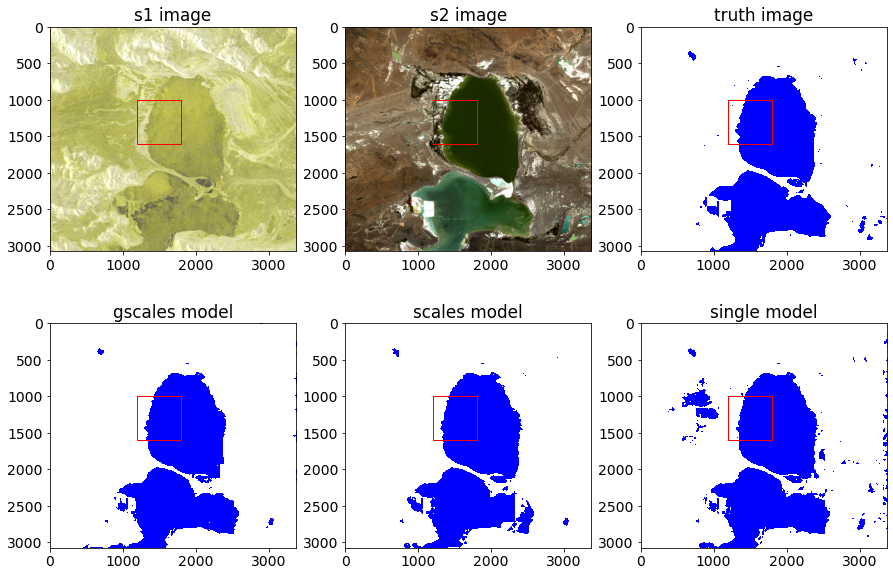

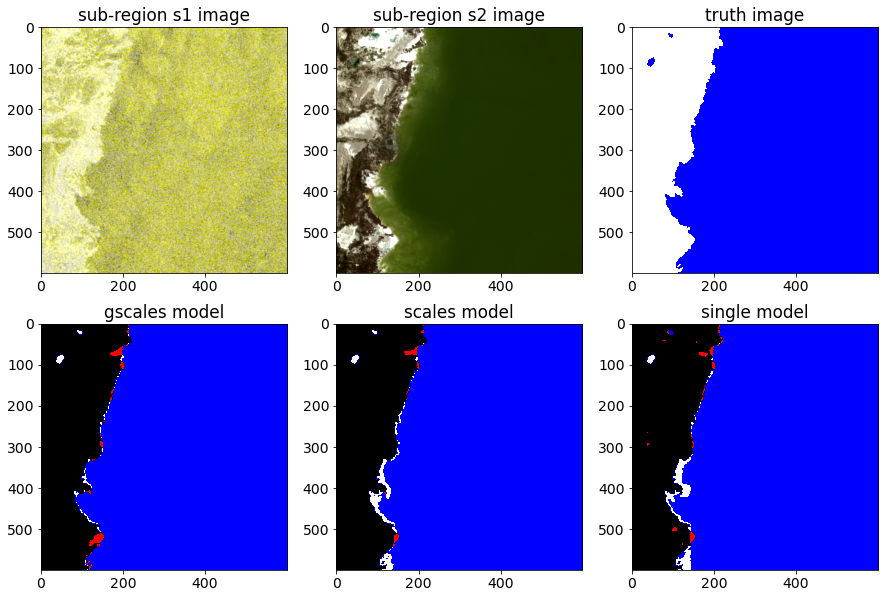

In [68]:
idx = 5
plt.rcParams.update({'font.size': 14})
img_list = [scene_[idx], s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx]]
print('size:', truth_[idx].shape)
sub_region = [1000, 1600, 1200, 1800]  ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
              s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(scene_[idx], color_bands=(0,0,1)); plt.title('s1 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,2); imgShow(s2_scene_[idx]); plt.title('s2 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
#### show the sub-region image
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(s1_scene_l, color_bands=(0,0,1)); plt.title('sub-region s1 image')
plt.subplot(2,3,2); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')


### Hard water body -> scene2 (✓2)

size: (3099, 3223)


Text(0.5, 1.0, 'single model')

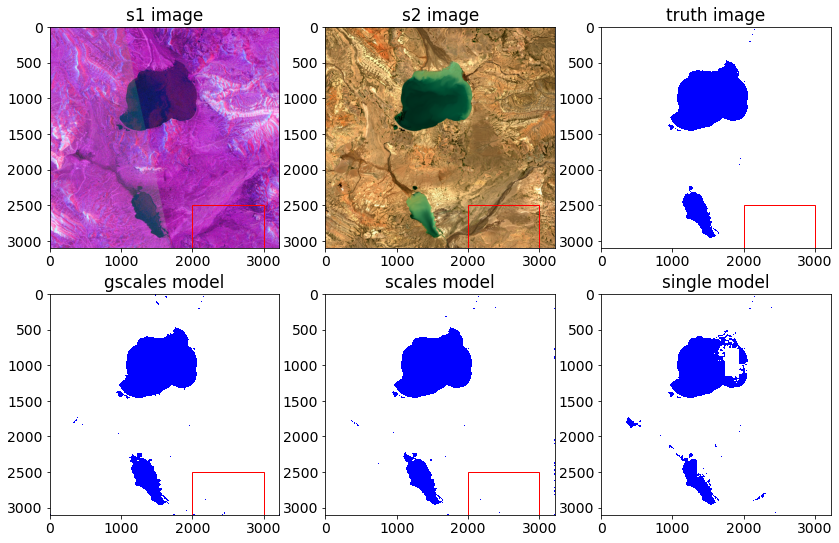

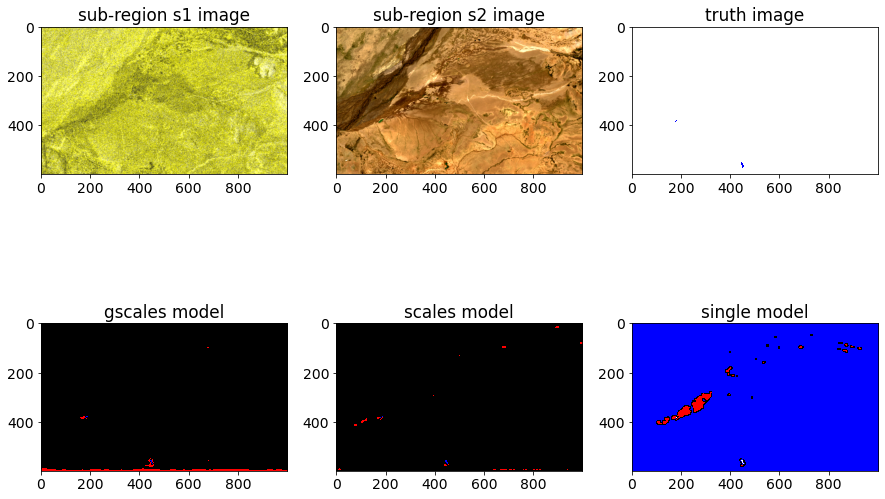

In [69]:
idx = 1
img_list = [scene_[idx], s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx]]
print('size:', truth_[idx].shape)
sub_region = [2500, 3500, 2000, 3000]       ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
                s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scene_[idx]); plt.title('s1 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,2); imgShow(s2_scene_[idx]); plt.title('s2 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
#### show the sub-region image
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(s1_scene_l, color_bands=(0,0,1)); plt.title('sub-region s1 image')
plt.subplot(2,3,2); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')



### Large-size water body -> scene6 (✓3)

size: (3076, 3373)


Text(0.5, 1.0, 'single model')

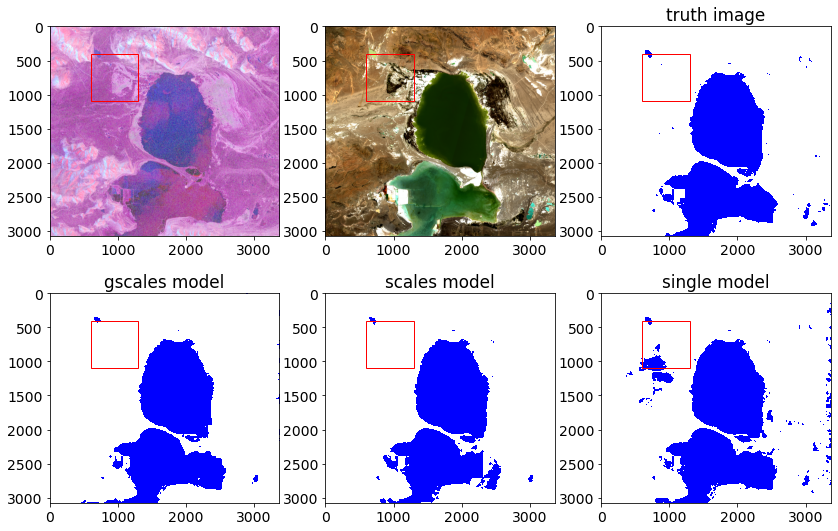

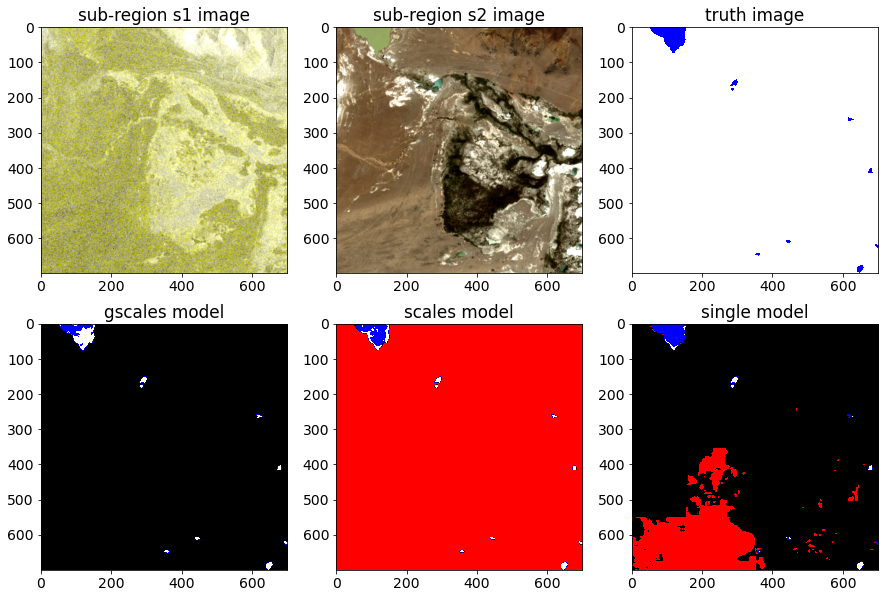

In [70]:
idx = 5
img_list = [scene_[idx], s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx]]
print('size:', truth_[idx].shape)
sub_region = [400, 1100, 600, 1300]     ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
                s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scene_[idx])
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,2); imgShow(s2_scene_[idx], clip_percent=5)
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
#### show the sub-region image
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(s1_scene_l, color_bands=(0,0,1)); plt.title('sub-region s1 image')
plt.subplot(2,3,2); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')

